In [ ]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import gutenberg
from nltk.probability import FreqDist
from collections import defaultdict
import string

nltk.download('gutenberg')
nltk.download('punkt')

text_words = [word.lower() for word in gutenberg.words('austen-emma.txt') if word.isalpha()]

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# TASK 0

In [ ]:
vocabulary = sorted(list(set(text_words)))
vocab_map = {word: i for i, word in enumerate(vocabulary)}
N = len(vocabulary)

sentences = [
    [word.lower() for word in sent if word.isalpha()]
    for sent in gutenberg.sents('austen-emma.txt')
]

def bag_of_words(document, vocab_map):
    """Створює вектор Bag-of-Words для документа."""
    bow_vector = np.zeros(len(vocab_map))
    for word in document:
        if word in vocab_map:
            bow_vector[vocab_map[word]] += 1
    return bow_vector

example_sentence = sentences[0]
bow_vector_example = bag_of_words(example_sentence, vocab_map)

print("--- Завдання 0: Bag-of-Words ---")
print(f"Розмір словника: {N}")
print(f"Приклад речення: {example_sentence}")
print(f"Його вектор BoW (перші 20 елементів): \n{bow_vector_example[:20]}")

--- Завдання 0: Bag-of-Words ---
Розмір словника: 7079
Приклад речення: ['emma', 'by', 'jane', 'austen']
Його вектор BoW (перші 20 елементів): 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# TASK 1

In [ ]:
from nltk import ngrams

bigrams = list(ngrams(text_words, 2))
bigram_vocabulary = sorted(list(set(bigrams)))
bigram_vocab_map = {bigram: i for i, bigram in enumerate(bigram_vocabulary)}
N_bigram = len(bigram_vocabulary)

def bag_of_ngrams(document_tokens, ngram_vocab_map, n=2):
    """Створює вектор Bag-of-Words для N-грам."""
    bon_vector = np.zeros(len(ngram_vocab_map))
    doc_ngrams = list(ngrams(document_tokens, n))
    for ngram in doc_ngrams:
        if ngram in ngram_vocab_map:
            bon_vector[ngram_vocab_map[ngram]] += 1
    return bon_vector

bon_vector_example = bag_of_ngrams(example_sentence, bigram_vocab_map, n=2)

print("\n--- Завдання 1: Bag-of-Words з N-грамами ---")
print(f"Розмір словника біграм: {N_bigram}")
print(f"Приклад речення: {example_sentence}")
print(f"Його вектор BoN (перші 20 елементів): \n{bon_vector_example[:20]}")


--- Завдання 1: Bag-of-Words з N-грамами ---
Розмір словника біграм: 65867
Приклад речення: ['emma', 'by', 'jane', 'austen']
Його вектор BoN (перші 20 елементів): 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# TASK 2/3

In [ ]:
from scipy.sparse import lil_matrix
from math import log2

def calculate_ppmi(corpus_words, window_size=5):
    vocab = sorted(list(set(corpus_words)))
    vocab_map = {word: i for i, word in enumerate(vocab)}
    N = len(vocab)

    co_occurrence_matrix = lil_matrix((N, N))
    for i, target_word in enumerate(corpus_words):
        if target_word not in vocab_map: continue
        
        start = max(0, i - window_size)
        end = min(len(corpus_words), i + window_size + 1)
        context_words = corpus_words[start:i] + corpus_words[i+1:end]
        
        for context_word in context_words:
            if context_word not in vocab_map: continue
            co_occurrence_matrix[vocab_map[target_word], vocab_map[context_word]] += 1

    co_occurrence_matrix = co_occurrence_matrix.tocsr()
    num_pairs = co_occurrence_matrix.sum()
    
    p_w = np.array(co_occurrence_matrix.sum(axis=1)).flatten() / num_pairs
    p_c = np.array(co_occurrence_matrix.sum(axis=0)).flatten() / num_pairs
    p_wc = co_occurrence_matrix / num_pairs

    ppmi_matrix = lil_matrix((N, N))
    
    rows, cols = p_wc.nonzero()
    for r, c in zip(rows, cols):
        if p_w[r] == 0 or p_c[c] == 0: continue
        
        pmi = log2(p_wc[r, c] / (p_w[r] * p_c[c]))
        ppmi_matrix[r, c] = max(0, pmi)
        
    return ppmi_matrix.tocsr(), vocab_map

emma_words = [word.lower() for word in gutenberg.words('austen-emma.txt') if word.isalpha()]
ppmi_window, vocab_map_window = calculate_ppmi(emma_words, window_size=5)

print("\n--- Завдання 2 та 3: PPMI ---")
print("PPMI матриця для 'austen-emma.txt' (ковзне вікно) успішно створена.")

man_idx = vocab_map_window['man']
woman_idx = vocab_map_window['woman']
good_idx = vocab_map_window['good']

print(f"PPMI(man, woman): {ppmi_window[man_idx, woman_idx]:.2f}")
print(f"PPMI(man, good): {ppmi_window[man_idx, good_idx]:.2f}")


--- Завдання 2 та 3: PPMI ---
PPMI матриця для 'austen-emma.txt' (ковзне вікно) успішно створена.
PPMI(man, woman): 1.07
PPMI(man, good): 0.94


# TASK 4

Проблема виникає через те, що PMI дуже чутливий до низьких частот. Якщо два рідкісних слова випадково зустрілися разом хоча б один раз, їхня спільна ймовірність P(w, c) може бути набагато вищою за добуток їхніх індивідуальних (дуже малих) ймовірностей P(w)P(c). Це створює штучно високе значення PMI, яке є статистичним шумом, а не реальною семантичною близькістю.

# TASK 5

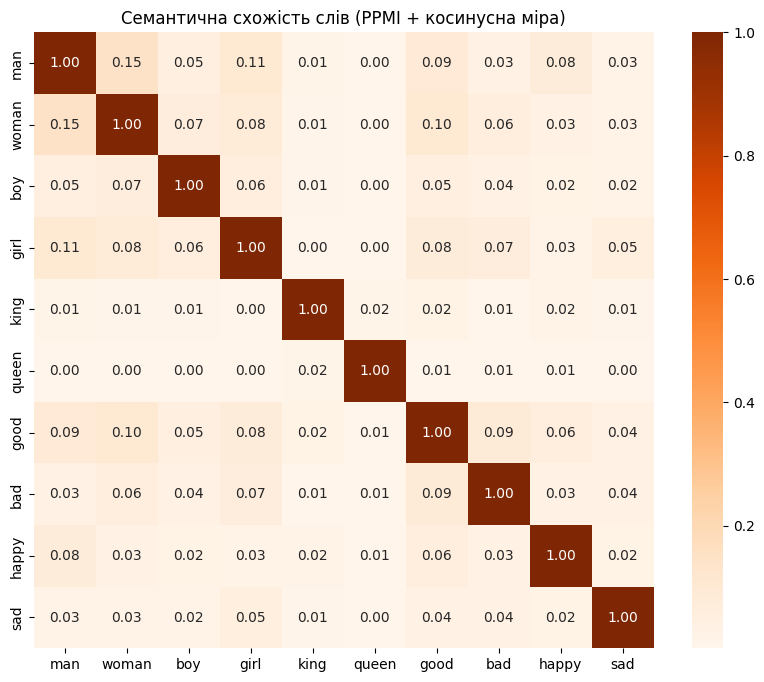


--- Завдання 5: Перевірка за допомогою тезауруса ---
Таблиця схожості:
        man  woman   boy  girl  king  queen  good   bad  happy   sad
man    1.00   0.15  0.05  0.11  0.01   0.00  0.09  0.03   0.08  0.03
woman  0.15   1.00  0.07  0.08  0.01   0.00  0.10  0.06   0.03  0.03
boy    0.05   0.07  1.00  0.06  0.01   0.00  0.05  0.04   0.02  0.02
girl   0.11   0.08  0.06  1.00  0.00   0.00  0.08  0.07   0.03  0.05
king   0.01   0.01  0.01  0.00  1.00   0.02  0.02  0.01   0.02  0.01
queen  0.00   0.00  0.00  0.00  0.02   1.00  0.01  0.01   0.01  0.00
good   0.09   0.10  0.05  0.08  0.02   0.01  1.00  0.09   0.06  0.04
bad    0.03   0.06  0.04  0.07  0.01   0.01  0.09  1.00   0.03  0.04
happy  0.08   0.03  0.02  0.03  0.02   0.01  0.06  0.03   1.00  0.02
sad    0.03   0.03  0.02  0.05  0.01   0.00  0.04  0.04   0.02  1.00


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

words_to_compare = ['man', 'woman', 'boy', 'girl', 'king', 'queen', 'good', 'bad', 'happy', 'sad']
indices = [vocab_map_window.get(word) for word in words_to_compare]

valid_words = [word for i, word in enumerate(words_to_compare) if indices[i] is not None]
valid_indices = [i for i in indices if i is not None]

word_vectors = ppmi_window[valid_indices, :]

similarity_matrix = cosine_similarity(word_vectors)

df_similarity = pd.DataFrame(similarity_matrix, index=valid_words, columns=valid_words)

plt.figure(figsize=(10, 8))
sns.heatmap(df_similarity, annot=True, cmap="Oranges", fmt=".2f")
plt.title("Семантична схожість слів (PPMI + косинусна міра)")
plt.show()

print("\n--- Завдання 5: Перевірка за допомогою тезауруса ---")
print("Таблиця схожості:")
print(df_similarity.round(2))